#Problem 1:

In [ ]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import math
import torch.nn.functional as F

In [ ]:
# Setting device for GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Loading MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

Using device: cpu


100%|██████████| 9912422/9912422 [00:00<00:00, 95641867.86it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 71214399.66it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26235115.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14722201.52it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# NN class definition
class DynamicMNISTModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_flag=0):
        super(DynamicMNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        layers = []

        # Choosing the activation function based on activation_flag
        if activation_flag == 1:
            activation = nn.Sigmoid()
        elif activation_flag == 2:
            activation = nn.Tanh()
        elif activation_flag == 3:
            activation = nn.ELU()
        else:
            # Default is ReLU
            activation = nn.ReLU()

        if len(hidden_sizes) == 0:
            # No hidden layers, only input and output layers
            layers.append(nn.Linear(input_size, output_size))
        else:
            # First layer
            layers.append(nn.Linear(input_size, hidden_sizes[0]))
            layers.append(nn.LayerNorm(hidden_sizes[0]))
            layers.append(activation)
            # Hidden layers
            for i in range(1, len(hidden_sizes)):
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
                layers.append(nn.LayerNorm(hidden_sizes[i]))
                layers.append(activation)
            # Output layer
            layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)

In [ ]:
# SGD Optimizer
def SGD_optim(model):
    return optim.SGD(model.parameters(), lr=0.0015, momentum=0.9)

In [ ]:
# Adam Optimizer
def Adam_optim(model):
    return optim.Adam(model.parameters(), lr=0.0015)

In [ ]:
# Training & Testing Model
def train_and_test_model(model, train_loader, test_loader, epochs=10, flag=1):
    optimizer = SGD_optim(model) if flag == 1 else Adam_optim(model)
    loss_function = nn.CrossEntropyLoss()
    model.to(device)

    total_training_time = 0

    for epoch in range(epochs):
        total_train_loss, total_train_samples = 0, 0
        total_test_loss, total_test_samples = 0, 0

        start_time = time.time()

        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            train_loss = loss_function(outputs, labels)
            train_loss.backward()
            optimizer.step()

            total_train_loss += train_loss.item() * labels.size(0)
            total_train_samples += labels.size(0)

        total_training_time += time.time() - start_time

        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                test_loss = loss_function(outputs, labels)

                total_test_loss += test_loss.item() * labels.size(0)
                total_test_samples += labels.size(0)

    average_train_loss_last_epoch = total_train_loss / total_train_samples
    average_test_loss_last_epoch = total_test_loss / total_test_samples
    print(f"train loss={average_train_loss_last_epoch}, test loss={average_test_loss_last_epoch}")

    return average_train_loss_last_epoch, average_test_loss_last_epoch, total_training_time

In [ ]:
def Problem4(hidden_sizes):
    model = DynamicMNISTModel(28*28, hidden_sizes, 10).to(device)
    avg_train_loss1, avg_test_loss1, train_time1 = train_and_test_model(model, train_loader, test_loader)
    return model

In [ ]:
# Train & Test for Decreasing size - best model from P4
hidden_sizes = [575, 475, 375, 250]
modelP4 = Problem4(hidden_sizes)

train loss=0.016592147344350813, test loss=0.06437768416907638


In [ ]:
# Train & Test for base model
hidden_sizes = []
modelbase = Problem4(hidden_sizes)

train loss=0.2889441215912501, test loss=0.28367612758874894


In [ ]:
modelP4.eval()
modelbase.eval()

DynamicMNISTModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [218]:
initial_images = torch.rand(10, 1, 28, 28, requires_grad=True)

lambda_reg = 0.1
def optimize_image(model, target_digit, initial_image, iterations=1000, learning_rate=0.01):
    image = initial_image.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([image], lr=learning_rate)
    # optimizer = torch.optim.SGD([image], lr=learning_rate, momentum=0.9)
    for i in range(iterations):
        optimizer.zero_grad()
        output = model(image)
        log_probs = F.log_softmax(output, dim=1)
        loss = -log_probs[0, target_digit]
        l2_reg = lambda_reg * torch.sum(image ** 2)
        total_loss = loss + l2_reg
        total_loss.backward()
        optimizer.step()
        image.data = image.data.clamp_(0, 1)
    return image.detach()

In [219]:
optimized_images_simple = [optimize_image(modelbase, digit, initial_images[digit].unsqueeze(0)) for digit in range(10)]
optimized_images_complex = [optimize_image(modelP4, digit, initial_images[digit].unsqueeze(0)) for digit in range(10)]

Base Model: 0 to 9 images


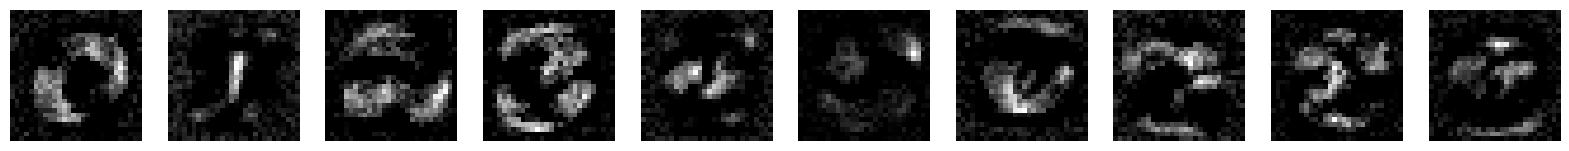

P4 Model: 0 to 9 images


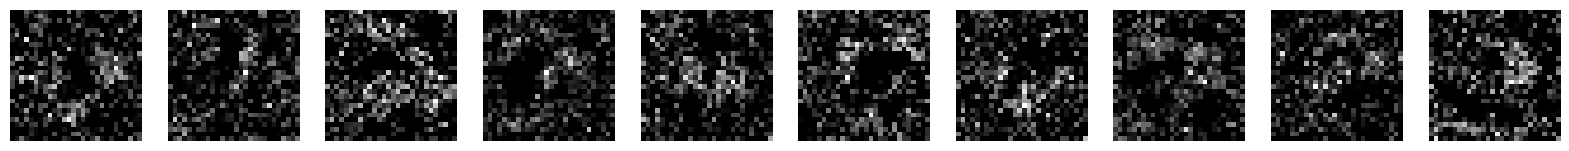

In [220]:
def show_images(images):
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze().cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

# Convert the list of tensors to a tensor for easy manipulation
optimized_images_simple_tensor = torch.cat([img for img in optimized_images_simple], dim=0)
optimized_images_complex_tensor = torch.cat([img for img in optimized_images_complex], dim=0)

print("Base Model: 0 to 9 images")
show_images(optimized_images_simple_tensor)
print("P4 Model: 0 to 9 images")
show_images(optimized_images_complex_tensor)

#Problem 2: